# Binary Classification Using Artificial Neural Networks

The most basic application of computer vision in the business context provided with the dataset is a simple neural network (Artificial Neural Network) set up to perform binary classification. The performance of this type of network will serve as a baseline for later network architectures. Given the difficulty of the problem, the performance of the networks in this notebook on a multiclass or multilabel classification problem would be too low for any reasonable deployment, so they will be performing binary classification. 

These networks require input data in a specific format, so the images will require some preprocessing. In order to conserve resources and reduce compute times, the arrays generated in the preprocessing steps of this notebook will be saved to the S3 bucket and reused in later notebooks with other network architectures.

## 1. Importing the Relevant Libraries and Packages

In [1]:
# Importing the relevant packages
import s3fs

import random as rn
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.utils.np_utils import to_categorical
from keras.models import Sequential 
from keras.layers import Dense
from keras.regularizers import l2

from sklearn.model_selection import train_test_split

seed = 6
np.random.seed(6)
rn.seed(6)
tf.random.set_seed(6)

Using TensorFlow backend.


## 2. Loading a Sample Image from S3

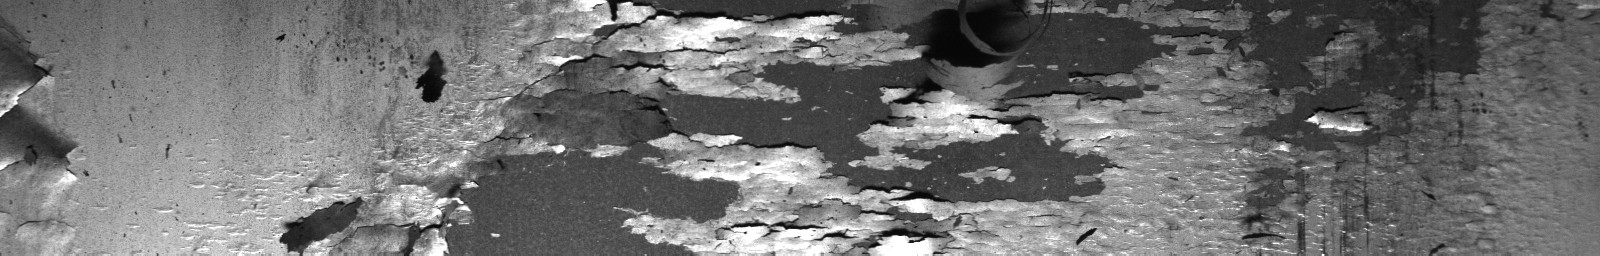

In [2]:
# Instancing an S3 FileSystem object
fs = s3fs.S3FileSystem()

# Making a list holding a filepath for every image in our training set 
path_list = fs.ls('s3://steel-training-dataset/training_images/train_images')

# This is a list all of our jpg filenames
filenames = [i.split('/')[-1] for i in path_list]

# Sanity check and displaying a training image
s3_1 = fs.open('s3://' + path_list[90])
image = load_img(s3_1, color_mode='grayscale')
image

To reduce the number of trainable parameters our models have, the images will be imported at a resolution of 256 x 256. 

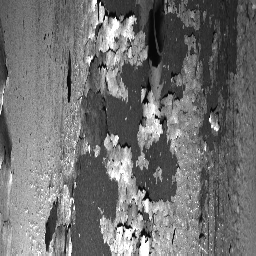

In [3]:
# What the images look like after downscaling 
image_small = load_img(s3_1, color_mode='grayscale', target_size=(256, 256))

image_small

In [4]:
# Converting our sample image to an array to see its shape
array = img_to_array(image_small)

array.shape

(256, 256, 1)

In [5]:
# Flattening our array and displaying the changes to its shape
flattened_array = np.ndarray.flatten(array)
 
flattened_array.shape

(65536,)

## 3. Importing and Preprocessing the Images

This function is used simplify importing and preprocessing steps. 

In [6]:
def img_conv_256x256(filepath_list):
    
    '''This function will take our list of filenames (array), 
    and load each image from the S3 bucket and convert it into
    an array, then scale that array between 0 and 1.'''
    
    image_arrays = []
    
    for i in filepath_list:
        
        s3_file = fs.open('s3://' + i)
        
        image = load_img(s3_file,
                         color_mode='grayscale',
                         target_size=(256,256))
        
        image_array = img_to_array(image)
        
        image_array_scaled = [i / 255 for i in image_array]

        image_arrays.append(image_array_scaled)

    return image_arrays

Running the function on our entire test set, in batches of 500

In [7]:
train_arrays = np.array([])

for i in range(26):
    
    path_list_section = path_list[:500]
    new_arrays = img_conv_256x256(path_list_section)
    train_arrays = np.append(train_arrays, new_arrays)
    if i < 26:
        path_list = path_list[500:]
    
    print(f'{round((i+1) * 3.84, 1)}% of the images have been processed.')

3.8% of the images have been processed.
7.7% of the images have been processed.
11.5% of the images have been processed.
15.4% of the images have been processed.
19.2% of the images have been processed.
23.0% of the images have been processed.
26.9% of the images have been processed.
30.7% of the images have been processed.
34.6% of the images have been processed.
38.4% of the images have been processed.
42.2% of the images have been processed.
46.1% of the images have been processed.
49.9% of the images have been processed.
53.8% of the images have been processed.
57.6% of the images have been processed.
61.4% of the images have been processed.
65.3% of the images have been processed.
69.1% of the images have been processed.
73.0% of the images have been processed.
76.8% of the images have been processed.
80.6% of the images have been processed.
84.5% of the images have been processed.
88.3% of the images have been processed.
92.2% of the images have been processed.
96.0% of the image

Right now the values stored in our array are precise to over 10 decimal places, this is way more than we need so to reduce the size of the array we will round each element to 2 decimal places. Our array is also currently 1-D, and our networks require that each training example be its own array, so after we round the values, we will reshape the array. 

In [8]:
# Rounding each value in train_arrays to two decimal places
train_arrays_rounded = np.round(train_arrays, 2)

# Reshaping the array into 12567 seperate arrays
arrays_reshaped = train_arrays_rounded.reshape(12567, 65536)

Later network architectures are going to use the same image training set, so repeating these preprocessing steps each time is not necessary; to avoid wasting computing resources the image arrays are being saved outside of this notebook. 

In [17]:
# Saving the image arrays for use in later notebooks
# np.save('image_and_label_arrays/image_arrays', arrays_reshaped)

## 4. Creating Binary Class Labels

In order for our networks to improve, they need the feedback from ground truth labels. Our labels come from a csv that was included with the images in the original data package. Since the networks in this notebook will be set up for binary classification, the labels will be set to either 0 or 1, indicating no defect, or the presence of defects respectively. 

In [9]:
# Accessing our csv file from S3
csv = fs.open('s3://steel-training-dataset/train.csv')

# Tranforming it into a pandas dataframe
train_df = pd.read_csv(csv)
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [10]:
# Making a list of zeroes to use as the default label 
zeroes  = [0 for x in range(len(filenames))]

# This dictionary has the jpg names as keys, and zeroes as values 
label_dict = dict(zip(filenames, zeroes))

# A list of every jpg that has a defect
defect_jpgs = list(set(train_df.ImageId))

# Updating label_dict, images with defects have their value set to 1
for i in defect_jpgs:
    label_dict[i] = 1

# Examining the first five rows
for i in range(5):
    index = list(label_dict.keys())[i]
    print(index, label_dict[index])

0002cc93b.jpg 1
00031f466.jpg 0
000418bfc.jpg 0
000789191.jpg 0
0007a71bf.jpg 1


In [11]:
# Turning our target labels into an array 
label_arr = list(label_dict.values())

# One hot encoding our binary labels
labels_ohe = to_categorical(label_arr)

# Sanity check
print(len(labels_ohe))

# Displaying the first five rows
labels_ohe[:5]

12567


array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [19]:
# Saving the label arrays for use in later notebooks
# np.save('image_and_label_arrays/label_arrays', labels_ohe)

## 5. Train Test Splits

In order to both train, and evaluate our networks, the image arrays must be seperated twice. The first split seperates the training data from the final evaluation (holdout) data. This is so when we train our networks and iterate on their architecture, we can run them on the holdout set at the end to evaluate their performance. It is key to avoid data leakage and the first train test split ensures that our networks have never been trained on the holdout data. 

We then take the training data, and split it into train and validation sets, so that our models can test themselves on the validation data each epoch, and improve their performance. 

In [12]:
# Split number 1: This holdout set wont return until the end of the notebook during evaluation
X_training, X_hold, y_training, y_hold = train_test_split(arrays_reshaped,
                                                          labels_ohe,
                                                          random_state = seed,
                                                          test_size = .1)

In [13]:
# Split number 2: Train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_training, 
                                                  y_training,
                                                  random_state = seed,
                                                  test_size = .3)

## 6. Modeling

In [14]:
# Defining a function to simplify graphing results
def graph_results(results):
    
    '''This function intakes a keras History object and graphs learning curves
    using Loss, and then Accuracy for both training and validation. '''
    
    hist = results.history
    
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.legend(['Loss', 'Val_Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(hist['acc'])
    plt.plot(hist['val_acc'])
    plt.legend(['Train Accuracy', 'Val Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

### 6.1 First Network

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4194368   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 4,198,658
Trainable params: 4,198,658
Non-trainable params: 0
_________________________________________________________________
Train on 7917 samples, validate on 3393 samples
Epoch 1/15
7917/7917 [==============================] - 9s 1ms/step - loss: 3.2557 - acc: 0.5854 - val_loss: 0.7082 - val_acc: 0.6310
Epoch 2/15
7917/7917 [==============================] - 8s 949us/step - loss: 0.6273 - acc: 0.6648 - val_loss: 0.5751 - val_acc: 0.7318
Epoch 3/15
7917/7917 [==============================] - 

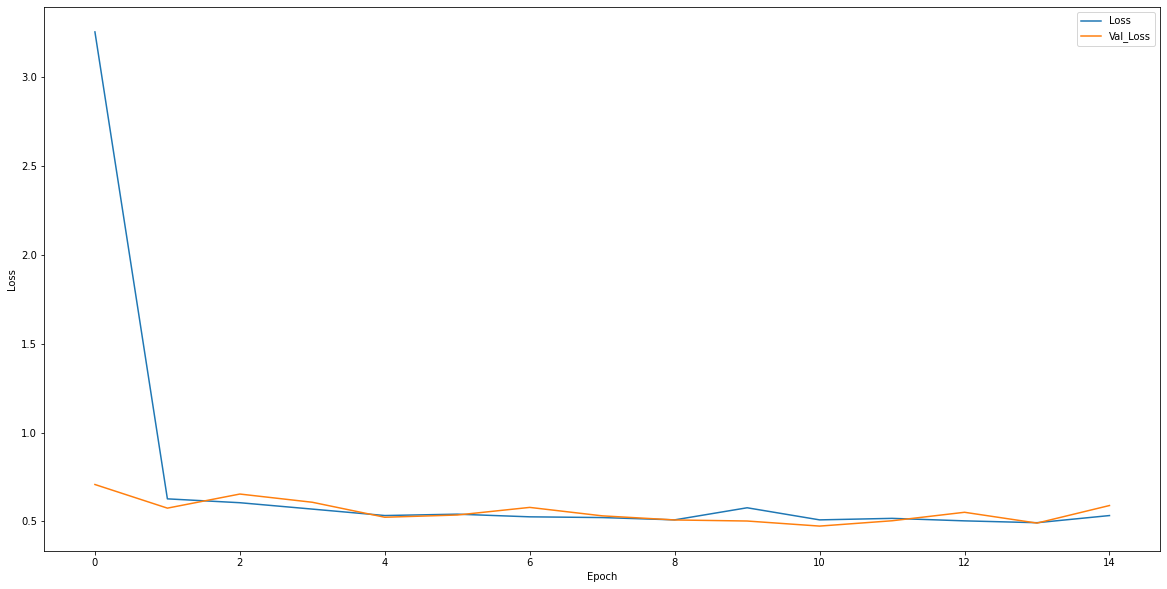

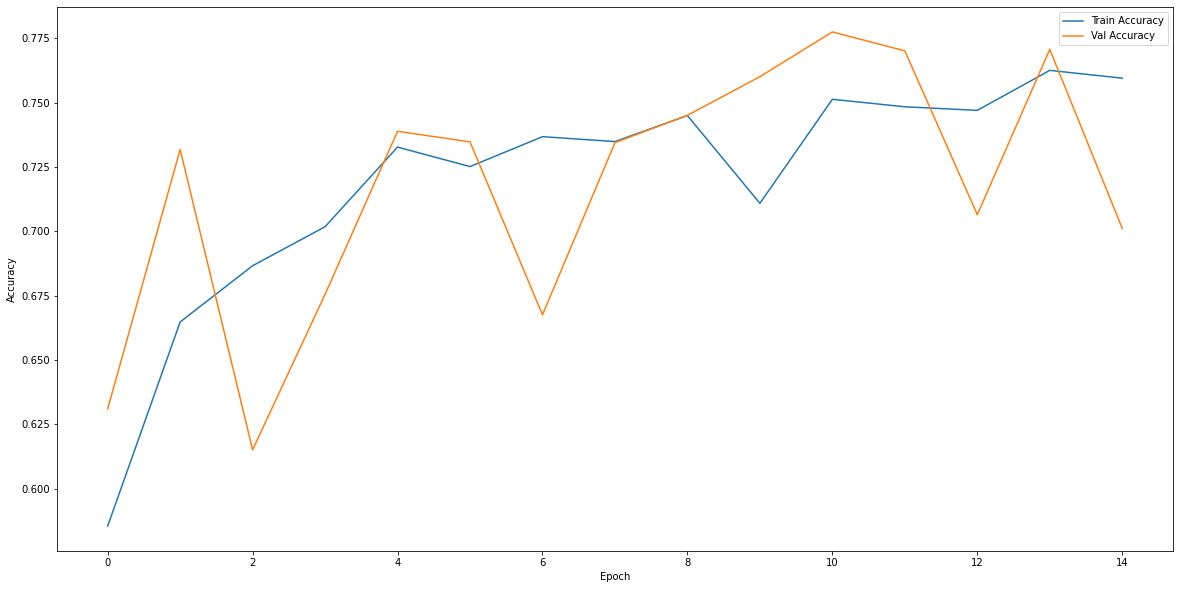

In [20]:
# Instantiating our network
neural_1 = Sequential()

# Adding layers
neural_1.add(Dense(64, activation = 'relu', input_shape=(65536,)))
neural_1.add(Dense(64, activation = 'relu'))
neural_1.add(Dense(2, activation='softmax'))

# Compiling 
neural_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Displaying the network structure
neural_1.summary()

# Fitting to the train data
neural_1_results = neural_1.fit(X_train, y_train, 
                                epochs = 15, 
                                batch_size = 32,
                                validation_data = (X_val, y_val),
                                verbose = 1)

# Visualizing network performance
graph_results(neural_1_results)

The curve tracking the accuracy on the training set is plateauing, this is indicative that this first network is struggling with the complexity of the task. To address this, the second network will have more hidden layers, and more nodes per layer. This added sophistication will hopefully increase performance. 

### 6.2 Network 2

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 258       
Total params: 8,438,530
Trainable params: 8,438,530
Non-trainable params: 0
_________________________________________________________________
Train on 7917 samples, validate on 3393 samples
Epoch 1/15
7917/7917 [==============================] - 16s 2m

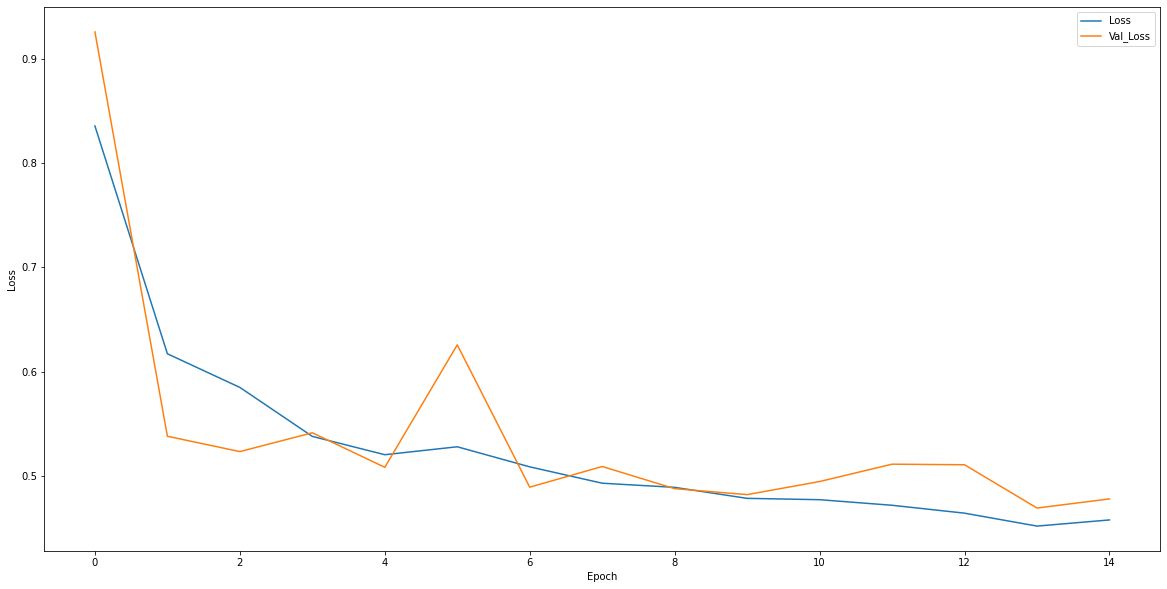

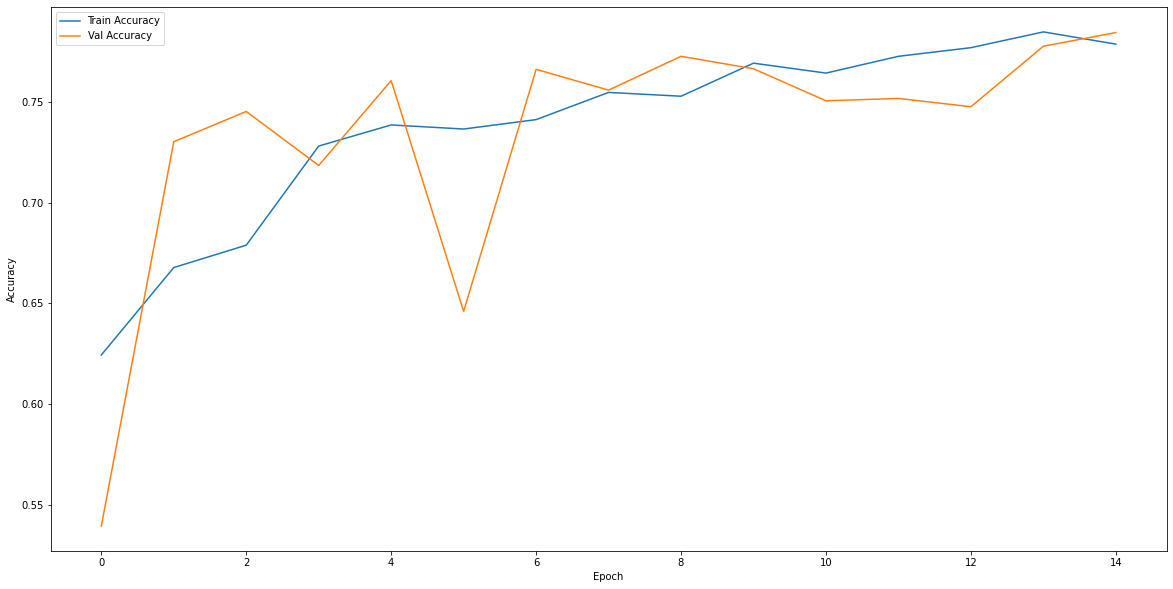

In [22]:
# Instantiating our network
neural_2 = Sequential()

# Adding layers
neural_2.add(Dense(128, activation = 'relu', input_shape=(65536,)))
neural_2.add(Dense(128, activation = 'relu'))
neural_2.add(Dense(128, activation = 'relu'))
neural_2.add(Dense(128, activation = 'relu'))
neural_2.add(Dense(2, activation='softmax'))

# Compiling 
neural_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Displaying the network structure
neural_2.summary()

# Fitting to the train data
neural_2_results = neural_2.fit(X_train, 
                                y_train, 
                                epochs = 15, 
                                batch_size = 32, 
                                validation_data = (X_val, y_val),
                                verbose = 1)

# Visualizing the results
graph_results(neural_2_results)

This second network is performing far better on the training set than the last network. It does appear however that the network is overfitting to the training set, as evidenced by the thrashing of the validation accuracy curve. To combat this, the next iteration will include regularization at each hidden layer. 

### 6.3 Network 3

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 128)               8388736   
_________________________________________________________________
dense_39 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_40 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_41 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 258       
Total params: 8,438,530
Trainable params: 8,438,530
Non-trainable params: 0
_________________________________________________________________
Train on 7917 samples, validate on 3393 samples
Epoch 1/15
7917/7917 [==============================] - 23s 3m

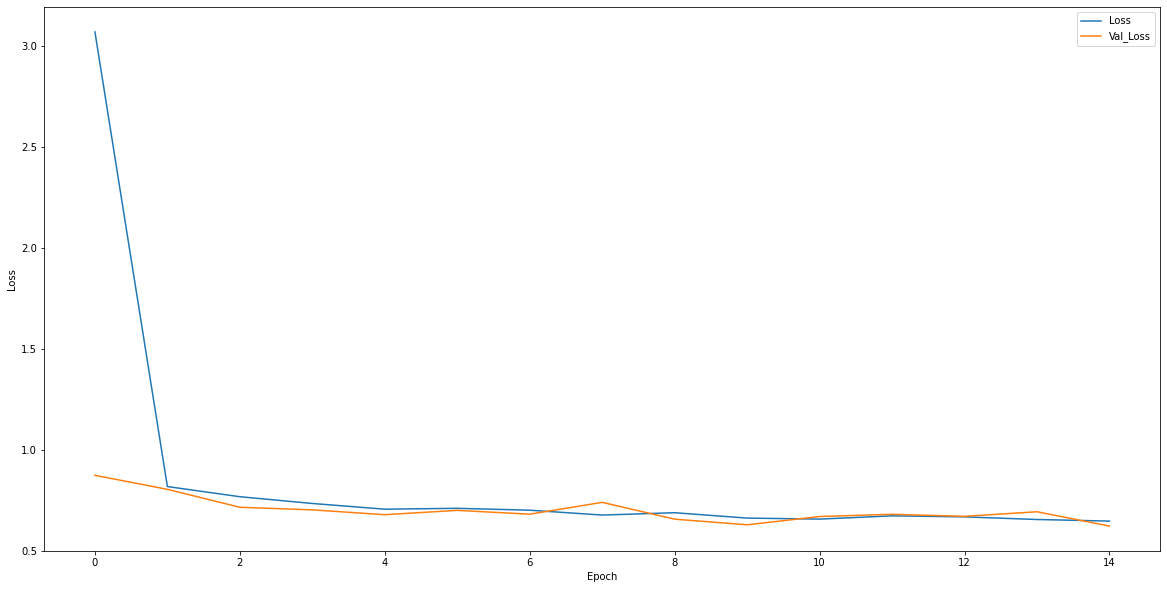

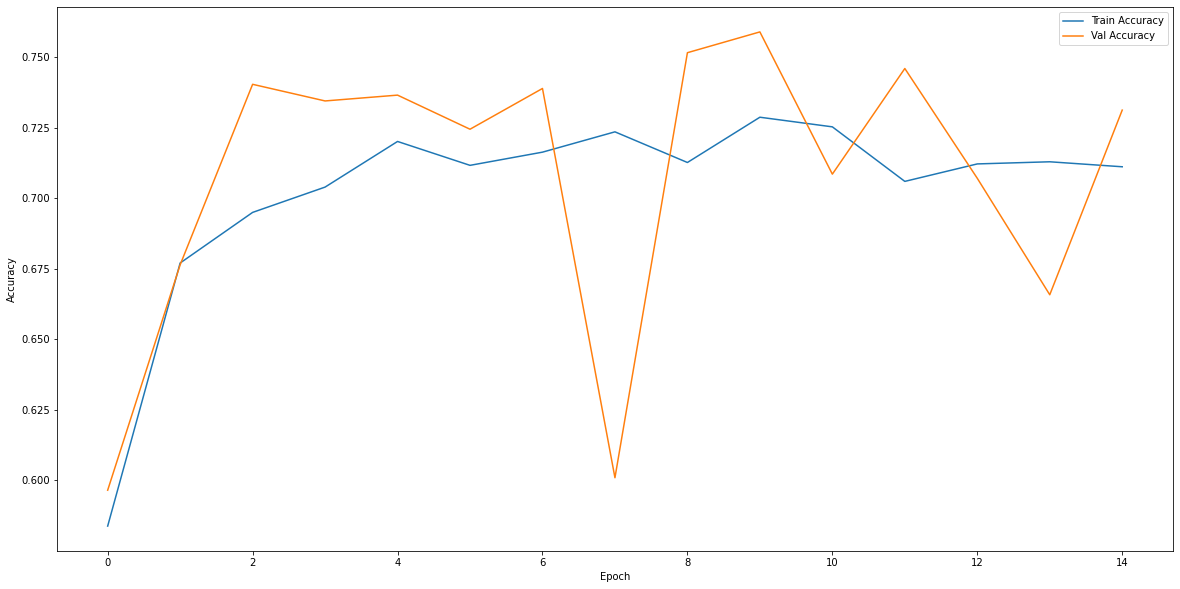

In [31]:
# Instantiating our network
neural_3 = Sequential()

# Adding layers
neural_3.add(Dense(128, activation = 'relu', input_shape = (65536,), kernel_regularizer = l2(0.001)))
neural_3.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.001)))
neural_3.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.001)))
neural_3.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.001)))
neural_3.add(Dense(2, activation='softmax'))

# Compiling 
neural_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Displaying the network structure
neural_3.summary()

# Fitting to the train data
neural_3_results = neural_3.fit(X_train, 
                                y_train, 
                                epochs = 15, 
                                batch_size = 32,
                                validation_data = (X_val, y_val),
                                verbose = 1)

# Visualizing the results
graph_results(neural_3_results)

Our train accuracy is plateauing, and our validation accuracy is thrashing wildly. Simple neural networks are likely not a viable approach to this task. 

## 7. Network Evaluation

To test the final network, we will feed our holdout set into our trained model. 

In [42]:
f'Final network accuracy: {round(neural_3.evaluate(X_hold, y_hold)[1]* 100, 2)}%'

1257/1257 [==============================] - 1s 537us/step


'Final network accuracy: 73.03%'

## 8. Conclusions For Binary Classification with Artificial Neural Networks

The motivation behind starting with the most basic possible neural network was to determine whether a simple A.N.N. could deliver business value. However even with the most simple possible version of a business use case, the artificial neural networks were simply not sophisticated enough for this difficult classification problem. The networks were either highly overfit to the training data, or unable to capture the complexity of the images at all. 

In the next notebook, the final evaluation accuracy of 73% will be compared to the performance of a convolutional neural network in the same binary classification task. However this process of exploring artificial neural networks, was still time well spent because it established a baseline model performance, and checked to see if the most computationally simple approach was worthwhile. This lackluster performance is not surprising, as artificial neural networks are not nearly as well suited to image classification tasks as other network architectures.